In [1]:
import pandas as pd
import numpy as np 
import os
import math
import itertools
import json
import time
import datetime
import requests
from datetime import date, timedelta, datetime, time
from calendar import monthrange
import matplotlib.pyplot as plt

In [2]:
# An example of Profile data, this will makes sense in a little while

url = "https://financialmodelingprep.com/api/v3/profile/MMM?apikey=aa8b4631b2ad1b2704741d1a2d6a2611"

response = requests.get(url)
data = response.json()
df_MMM_profile_all_data = pd.DataFrame(data)
df_MMM_profile = df_MMM_profile_all_data[["symbol","companyName","cik","industry","sector","exchangeShortName"]]
df_MMM_profile

#Note the cik number is unique to the company, even if the symbol changes or the name the cik will stay

def get_all_data_for_symobol_daily(symbol):
    """Gets all  daily data for a given ticker
     
    Arguments : 6
    symbol : what symbol to get data for 
    """
    big_df = pd.read_csv("https://0-source-principal-administrative.s3.amazonaws.com/0-public-data/ALLDAILYDATA.csv")
    big_df = big_df[big_df['Ticker'] == symbol]  # filtering
    big_df = big_df.dropna(how = 'all',subset = ['Date',"Ticker"])
    big_df.to_csv(f"{symbol}_ALLDATADAILY.csv")


def get_data_presentation_type_1(data,ascending = True):
    """Convert the DataFrame into type1(order by Symbol then Date then Timestamp)
    If ascending is passed as False automatically converts to type 2 instead 

    Args:
    data :The data to convert"""
    if "Timestamp" in data.columns : 
            data["Time"] = data['Timestamp']
            del data['Timestamp']
            data['Symbol'] = data['Ticker']
            del data['Ticker']
            data['Symbol'] = data.Symbol.astype(str).str.upper()
            data['Open'] = data['OpenPrice']
            del data['OpenPrice']
            data['Close'] = data['ClosePrice']
            del data['ClosePrice']
            data['High'] = data['HighPrice']
            del data['HighPrice']
            data['Low'] = data['LowPrice']
            del data['LowPrice']
            data['Volume'] = data['TotalVolume']
            del data['TotalVolume']
            data = data.sort_values(by = ['Symbol',"Date","Time"], ascending= ascending)

    else : 
            data['Symbol'] = data['Ticker']
            del data['Ticker']
            data['Symbol'] = data.Symbol.astype(str).str.upper()
            data['Open'] = data['open']
            del data['open']
            data['Close'] = data['close']
            del data['close']
            data['High'] = data['high']
            del data['high']
            data['Low'] = data['low']
            del data['low']
            data['Volume'] = data['volume']
            del data['volume']
            data = data.sort_values(by = ['Symbol',"Date"],ascending = ascending)

    return data 


from datetime import date, timedelta, datetime
from dateutil.parser import parse
pd.options.mode.chained_assignment = None 
def get_start_end_only_data_custom(data,start_date_, end_date_=None):
    """Gets all data between two given dates 

    Args: 
    data :What data to perform the calculations on 
    start_date : The start date for the data 
    end_date : the end date for the data"""
    if start_date_:
        start_date = datetime(start_date_.year,start_date_.month,start_date_.day)
    if end_date_:
        end_date = 	datetime(end_date_.year,end_date_.month,end_date_.day)
    if "Time" not in data.columns : 
        Date =list(data.Date)
        date = []
        for _ in Date: 
            _ = str(_)
            date.append(f'{_[:4]}-{_[4:6]}-{_[6:]}')
        try :
            data.Date  = pd.to_datetime(date) 
        except: 
            pass
        if end_date :
            mask = (data['Date'] >= start_date) & (data['Date'] <= end_date)
        else: 
            mask = (data['Date'] >= start_date)
        return data.loc[mask]
    else: 
        try : 
            data.Time = data.Time.map(lambda x: datetime.strptime(x,"%H:%M:%S").time())
        except: pass
        Date =list(data.Date)
        start_time  = start_date_.time()
        date = []
        for _ in Date: 
            _ = str(_)
            date.append(f'{_[:4]}-{_[4:6]}-{_[6:]}')
        try: 
            data.Date  = pd.to_datetime(date) 
        except:pass
        if end_date :
            end_time  = end_date_.time()
            mask = (data['Date'] >= start_date) & (data['Date'] <= end_date ) &( data['Time'] >= start_time) & (data['Time'] <  end_time)
        else: 
            mask = (data['Date'] >= start_date) & ( data['Time'] >= start_time)
        return data.loc[mask]

# Getting MMM daily data
get_all_data_for_symobol_daily("MMM")

#Dataframe of MMM_ALLDATADAILY.csv == df_MMM_d after applying get_data_presentation_type_1 function
df_MMM_d = pd.read_csv('MMM_ALLDATADAILY.csv')
df_MMM_d

df_MMM_m = pd.read_csv("MMM_ALLDATAMINUTE.csv")

df_MMM_m

df_MMM_m_type_1 = get_data_presentation_type_1(df_MMM_m,ascending = True)
df_MMM_d_type_1 = get_data_presentation_type_1(df_MMM_d,ascending = True)



df_MMM_m_type_1.drop(['Unnamed: 0'], axis=1, inplace=True)
df_MMM_m_type_1.drop(['Unnamed: 0.1'], axis=1, inplace=True)
df_MMM_m_type_1.drop(['TotalQuantity'], axis=1, inplace=True)
df_MMM_m_type_1.drop(['TotalTradeCount'], axis=1, inplace=True)


# For Daily Data
df_MMM_d_type_1.drop(['Unnamed: 0'], axis=1, inplace=True)
df_MMM_d_type_1.drop(['Unnamed: 0.1'], axis=1, inplace=True)



print("Minute Data")
df_MMM_m_type_1



    

def get_time_with_given_interval(date,interval,last_hour=None,last_minute=None):
    """Gets time from 9:00:00 to 16:00:00 with given interval"""

    date  = parse(str(date))
    start_time =  datetime(date.year,date.month,date.day,9,30)
    if  last_hour==None : 
        end_time  =datetime(date.year,date.month,date.day,16)
    else :
        end_time  =datetime(date.year,date.month,date.day,16,last_hour,last_minute)
    list_of_times = []
    while start_time!=end_time :
        list_of_times.append([start_time,start_time+ timedelta(minutes = interval)])
        start_time  = start_time+ timedelta(minutes = interval)
        if start_time <=end_time :
            continue
        else: 
            break
    return list_of_times

def getconvert_minuteto_traditional  (data, convert_type,  trading_hours_criteria,last_hour= None,last_minute= None):
    """Converts minute data to 5 minute , 15 minute , 30 minute , 1 hour , 2 hour and 5 hour data type 

    Arguments : 
    data : data to work with
    convert_type : what type to convert to 
    trading_hours_criteria : wether to work within trading hours or with all data"""

    dataframe_final ={
        "Date":[],
        "Time":[],
        "Open":[],
        "Close":[],
        "High":[],
        "Low":[],
        "Volume":[],
        "Symbol":[],
        "TotalQuantity":[],
        "TotalTradeCount":[]
        }
    if trading_hours_criteria == False :

        symbols = data.Symbol.unique()
        for symbol in symbols : 
            symbol_df = data[data['Symbol'] == symbol]
            dates = symbol_df.Date.unique()
            for date in dates : 
                date_symbol_df = symbol_df[symbol_df['Date'] == date]
                for step in range( convert_type,len(date_symbol_df),  convert_type):
                    remaining = len(date_symbol_df)- step 
                    current_dataframe = date_symbol_df.iloc[step-convert_type:step]
                    dataframe_final['Date'].append(current_dataframe['Date'].iloc[0])
                    dataframe_final['Time'].append(current_dataframe['Time'].iloc[0])
                    dataframe_final['Open'].append(current_dataframe['Open'].iloc[0])
                    dataframe_final['Close'].append(current_dataframe['Close'].iloc[-1])
                    dataframe_final["High"].append(max(current_dataframe['High']))
                    dataframe_final["Low"].append(min(current_dataframe['Low']))
                    dataframe_final["Volume"].append(sum(current_dataframe['Volume']))
                    if "TotalQuantity" in current_dataframe.columns : 

                        dataframe_final["TotalQuantity"].append(sum(current_dataframe['TotalQuantity']))
                    else : 
                        dataframe_final['TotalQuantity'].append(None)
                    if "TotalTradeCount" in current_dataframe.columns : 

                        dataframe_final["TotalTradeCount"].append(sum(current_dataframe['TotalTradeCount']))
                    else : 
                        dataframe_final["TotalTradeCount"].append(None)
                    dataframe_final['Symbol'].append(current_dataframe['Symbol'].iloc[0])
                if remaining != 0 : 
                    current_dataframe = date_symbol_df[len(date_symbol_df)-remaining : ]
                    dataframe_final['Date'].append(current_dataframe['Date'].iloc[0])
                    dataframe_final['Time'].append(current_dataframe['Time'].iloc[0])
                    dataframe_final['Open'].append(current_dataframe['Open'].iloc[0])
                    dataframe_final['Close'].append(current_dataframe['Close'].iloc[-1])
                    dataframe_final["High"].append(max(current_dataframe['High']))
                    dataframe_final["Low"].append(min(current_dataframe['Low']))
                    dataframe_final["Volume"].append(sum(current_dataframe['Volume']))
                    if "TotalQuantity" in current_dataframe.columns : 

                        dataframe_final["TotalQuantity"].append(sum(current_dataframe['TotalQuantity']))
                    else : 
                        dataframe_final['TotalQuantity'].append(None)
                    if "TotalTradeCount" in current_dataframe.columns : 

                        dataframe_final["TotalTradeCount"].append(sum(current_dataframe['TotalTradeCount']))
                    else : 
                        dataframe_final["TotalTradeCount"].append(None)
                    dataframe_final['Symbol'].append(current_dataframe['Symbol'].iloc[0])
    elif trading_hours_criteria== True :
        data.Time =data.Time.astype(str)
        if last_hour ==None : 
            data = data[data['Time'] >= "09:30:00" ]
            data = data[data['Time'] <= "16:00:00"]
        else:
            #if len(str(last_minute))==1 :
            last_minute_ = "0"+str(last_minute)
            data = data[data['Time'] >= "09:30:00" ]
            data = data[data['Time'] <= f"{last_hour}:{last_minute_}:00"]			
        symbols = data.Symbol.unique()
        for symbol in symbols : 
            symbol_df = data[data['Symbol'] == symbol]
            dates = symbol_df.Date.unique()
            for date in dates : 

                date_symbol_df = symbol_df[symbol_df['Date'] == date]
                list_of_times_= get_time_with_given_interval(date,convert_type,last_hour,last_minute)
                for time in list_of_times_:
                    current_dataframe = get_start_end_only_data_custom(date_symbol_df,time[0],time[1])
                    try:
                        dataframe_final['Date'].append(current_dataframe['Date'].iloc[0])
                        dataframe_final['Time'].append(current_dataframe['Time'].iloc[0])
                        dataframe_final['Open'].append(current_dataframe['Open'].iloc[0])
                        dataframe_final['Close'].append(current_dataframe['Close'].iloc[-1])
                        dataframe_final["High"].append(max(current_dataframe['High']))
                        dataframe_final["Low"].append(min(current_dataframe['Low']))
                        dataframe_final["Volume"].append(sum(current_dataframe['Volume']))
                        if "TotalQuantity" in current_dataframe.columns : 

                            dataframe_final["TotalQuantity"].append(sum(current_dataframe['TotalQuantity']))
                        else : 
                            dataframe_final['TotalQuantity'].append(None)
                        if "TotalTradeCount" in current_dataframe.columns : 

                            dataframe_final["TotalTradeCount"].append(sum(current_dataframe['TotalTradeCount']))
                        else : 
                            dataframe_final["TotalTradeCount"].append(None)
                        dataframe_final['Symbol'].append(current_dataframe['Symbol'].iloc[0])
                    except:
                        pass

    #convert to dataframe
    df_minute = pd.DataFrame(dataframe_final)
    df_minute.Date = df_minute.Date.astype(str)
    final_final_Dates = []
    for date in df_minute.Date:
        final_final_Dates.append(date.replace('-',''))
    df_minute.Date = final_final_Dates
    df_minute.Date = df_minute.Date.astype(int)

    if 'TotalTradeCount' not in data.columns:
        del df_minute['TotalTradeCount']

    if 'TotalQuantity' not in data.columns:
        del df_minute['TotalQuantity']

    return df_minute
    
def getconvert_minuteto_mathametical (data, convert_type,  trading_hours_criteria):
    """Converts minute data to 5 minute , 15 minute , 30 minute , 1 hour , 2 hour and 5 hour data type 
        
    Arguments : 
    data : data to work with
    convert_type : what type to convert to 
    trading_hours_criteria : wether to work within trading hours or with all data"""

    dataframe_final ={
        "Date":[],
        "Time":[],
        "Open":[],
        "Close":[],
        "High":[],
        "Low":[],
        "Volume":[],
        "Symbol":[],
        "TotalQuantity":[],
        "TotalTradeCount":[]
        }
    if trading_hours_criteria == False :

        symbols = data.Symbol.unique()
        for symbol in symbols : 
            symbol_df = data[data['Symbol'] == symbol]
            dates = symbol_df.Date.unique()
            for date in dates : 
                date_symbol_df = symbol_df[symbol_df['Date'] == date]
                for step in range( convert_type,len(date_symbol_df),  convert_type):
                    remaining = len(date_symbol_df)- step 
                    current_dataframe = date_symbol_df.iloc[step-convert_type:step]
                    dataframe_final['Date'].append(current_dataframe['Date'].iloc[0])
                    dataframe_final['Time'].append(current_dataframe['Time'].iloc[0])
                    dataframe_final['Open'].append(current_dataframe['Open'].iloc[0])
                    dataframe_final['Close'].append(current_dataframe['Close'].iloc[-1])
                    dataframe_final["High"].append(max(current_dataframe['High']))
                    dataframe_final["Low"].append(min(current_dataframe['Low']))
                    dataframe_final["Volume"].append(sum(current_dataframe['Volume']))
                    if "TotalQuantity" in current_dataframe.columns : 

                        dataframe_final["TotalQuantity"].append(sum(current_dataframe['TotalQuantity']))
                    else : 
                        
                        dataframe_final['TotalQuantity'].append(None)
                    if "TotalTradeCount" in current_dataframe.columns : 

                        dataframe_final["TotalTradeCount"].append(sum(current_dataframe['TotalTradeCount']))
                    else : 
                        dataframe_final["TotalTradeCount"].append(None)
                    dataframe_final['Symbol'].append(current_dataframe['Symbol'].iloc[0])
            if remaining != 0 : 
                    current_dataframe = date_symbol_df[len(date_symbol_df)-remaining : ]
                    dataframe_final['Date'].append(current_dataframe['Date'].iloc[0])
                    dataframe_final['Time'].append(current_dataframe['Time'].iloc[0])
                    dataframe_final['Open'].append(current_dataframe['Open'].iloc[0])
                    dataframe_final['Close'].append(current_dataframe['Close'].iloc[-1])
                    dataframe_final["High"].append(max(current_dataframe['High']))
                    dataframe_final["Low"].append(min(current_dataframe['Low']))
                    dataframe_final["Volume"].append(sum(current_dataframe['Volume']))
                    if "TotalQuantity" in current_dataframe.columns : 

                        dataframe_final["TotalQuantity"].append(sum(current_dataframe['TotalQuantity']))
                    else : 
                        dataframe_final['TotalQuantity'].append(None)
                    if "TotalTradeCount" in current_dataframe.columns : 

                        dataframe_final["TotalTradeCount"].append(sum(current_dataframe['TotalTradeCount']))
                    else : 
                        dataframe_final["TotalTradeCount"].append(None)
                    dataframe_final['Symbol'].append(current_dataframe['Symbol'].iloc[0])
    elif trading_hours_criteria== True :
        data.Time =data.Time.astype(str)
        data = data[data['Time'] >= "09:30:00" ]
        data = data[data['Time'] <= "16:00:00"]
        symbols = data.Symbol.unique()
        for symbol in symbols : 
            symbol_df = data[data['Symbol'] == symbol]
            dates = symbol_df.Date.unique()
            for date in dates : 
                date_symbol_df = symbol_df[symbol_df['Date'] == date]
                for step in range( convert_type,len(date_symbol_df),  convert_type):
                    remaining = len(date_symbol_df)- step 
                    current_dataframe = date_symbol_df.iloc[step-convert_type:step]
                    dataframe_final['Date'].append(current_dataframe['Date'].iloc[0])
                    dataframe_final['Time'].append(current_dataframe['Time'].iloc[0])
                    dataframe_final['Open'].append(current_dataframe['Open'].iloc[0])
                    dataframe_final['Close'].append(current_dataframe['Close'].iloc[-1])
                    dataframe_final["High"].append(max(current_dataframe['High']))
                    dataframe_final["Low"].append(min(current_dataframe['Low']))
                    dataframe_final["Volume"].append(sum(current_dataframe['Volume']))
                    if "TotalQuantity" in current_dataframe.columns : 

                        dataframe_final["TotalQuantity"].append(sum(current_dataframe['TotalQuantity']))
                    else : 
                        dataframe_final['TotalQuantity'].append(None)
                    if "TotalTradeCount" in current_dataframe.columns : 

                        dataframe_final["TotalTradeCount"].append(sum(current_dataframe['TotalTradeCount']))
                    else : 
                        dataframe_final["TotalTradeCount"].append(None)
                    dataframe_final['Symbol'].append(current_dataframe['Symbol'].iloc[0])
                if remaining != 0 : 
                    current_dataframe = date_symbol_df[len(date_symbol_df)-remaining : ]
                    dataframe_final['Date'].append(current_dataframe['Date'].iloc[0])
                    dataframe_final['Time'].append(current_dataframe['Time'].iloc[0])
                    dataframe_final['Open'].append(current_dataframe['Open'].iloc[0])
                    dataframe_final['Close'].append(current_dataframe['Close'].iloc[-1])
                    dataframe_final["High"].append(max(current_dataframe['High']))
                    dataframe_final["Low"].append(min(current_dataframe['Low']))
                    dataframe_final["Volume"].append(sum(current_dataframe['Volume']))
                    if "TotalQuantity" in current_dataframe.columns : 

                        dataframe_final["TotalQuantity"].append(sum(current_dataframe['TotalQuantity']))
                    else : 
                        
                        dataframe_final['TotalQuantity'].append(None)
                        
                    if "TotalTradeCount" in current_dataframe.columns : 

                        dataframe_final["TotalTradeCount"].append(sum(current_dataframe['TotalTradeCount']))
                    else : 
    
                        dataframe_final["TotalTradeCount"].append(None)
                    dataframe_final['Symbol'].append(current_dataframe['Symbol'].iloc[0])
    #convert to dataframe
    df_minute = pd.DataFrame(dataframe_final)
    if 'TotalTradeCount' not in data.columns:
        del df_minute['TotalTradeCount']

    if 'TotalQuantity' not in data.columns:
        del df_minute['TotalQuantity']



    return df_minute

    
def getconvert_dailyto_mathamtical(data,amount):
    """Converts daily data to different types of data
    Arguments : 
     data : data to work with
    amount : what frequencey to work with """
    
    year = []
    month = []
    week = []
    day = []
    dataframe_final ={
        "Date":[],
        "Open":[],
        "Close":[],
        "High":[],
        "Low":[],
        "Volume":[],
        "Symbol":[],
        }
    for date in data.Date:
        date = str(date)
        date_time_obj = datetime.strptime(date, '%Y%m%d')
        week.append(date_time_obj.date().isocalendar()[1])
        month.append(date_time_obj.month)
        year.append(date_time_obj.year)
        day.append(date_time_obj.isoweekday())
    data['Month'] = month
    data["Year"] = year
    data['Week'] = week
    data["Day"]  = day
    symbols = data.Symbol.unique()
    for symbol in symbols : 
            date_symbol_df = data[data['Symbol'] == symbol]
            for step in range( amount,len(date_symbol_df),  amount): 
                remaining = len(date_symbol_df)- step 
                current_dataframe = date_symbol_df.iloc[step-amount:step]
                dataframe_final['Date'].append(current_dataframe['Date'].iloc[0])
                dataframe_final['Open'].append(current_dataframe['Open'].iloc[0])
                dataframe_final['Close'].append(current_dataframe['Close'].iloc[-1])
                dataframe_final["High"].append(max(current_dataframe['High']))
                dataframe_final["Low"].append(min(current_dataframe['Low']))
                dataframe_final["Volume"].append(sum(current_dataframe['Volume']))
                dataframe_final['Symbol'].append(current_dataframe['Symbol'].iloc[0])
            if remaining != 0 : 
                current_dataframe = date_symbol_df[len(date_symbol_df)-remaining : ]
                dataframe_final['Date'].append(current_dataframe['Date'].iloc[0])
                dataframe_final['Open'].append(current_dataframe['Open'].iloc[0])
                dataframe_final['Close'].append(current_dataframe['Close'].iloc[-1])
                dataframe_final["High"].append(max(current_dataframe['High']))
                dataframe_final["Low"].append(min(current_dataframe['Low']))
                dataframe_final["Volume"].append(sum(current_dataframe['Volume']))
                dataframe_final['Symbol'].append(current_dataframe['Symbol'].iloc[0])
    #convert to dataframe
    df_daily = pd.DataFrame(dataframe_final)
    return df_daily
    
def getconvert_dailyto_traditional(data,amount,convert_type):
    """Converts daily data to ""Daily" "Weekly" "Monthly" "Yearly"
    Arguments : 
     data : data to work with
    amount : what frequencey to work with
    convert_type : what type to convert to  """
    year = []
    month = []
    week = []
    dataframe_final ={
        "Date":[],
        "Open":[],
        "Close":[],
        "High":[],
        "Low":[],
        "Volume":[],
        "Symbol":[],
        }
    for date in data.Date:
        date = str(date)
        date_time_obj = datetime.strptime(date, '%Y%m%d')
        week.append(date_time_obj.date().isocalendar()[1])
        month.append(date_time_obj.month)
        year.append(date_time_obj.year)
    data['Month'] = month
    data["Year"] = year
    data['Week'] = week

    symbols = data.Symbol.unique()
    if convert_type == "Daily": 
        dataframe_final = pd.DataFrame(getconvert_dailyto_mathamtical(data,amount))
    elif convert_type == "Weekly":
        dataframe_weekly ={
        "Date":[],
        "Open":[],
        "Close":[],
        "High":[],
        "Low":[],
        "Volume":[],
        "Symbol":[],
        }
        for current_symbol in symbols :
            symbol_data = data[data["Symbol"]== current_symbol]
            years_we_have = symbol_data.Year.unique()
            for year in years_we_have : 
                data_for_current_year = symbol_data[symbol_data["Year"] == year]
                weeks_for_current_year = data_for_current_year.Week.unique()
                for week in weeks_for_current_year : 
                    data_for_current_week_for_current_year = data_for_current_year[data_for_current_year['Week'] == week]
                    data_for_current_week_for_current_year = data_for_current_week_for_current_year.sort_values(["Date"],ascending = True)
                    dataframe_weekly['Date'].append(data_for_current_week_for_current_year['Date'].iloc[0])
                    dataframe_weekly['Open'].append(data_for_current_week_for_current_year['Open'].iloc[0])
                    dataframe_weekly['Close'].append(data_for_current_week_for_current_year['Close'].iloc[-1])
                    dataframe_weekly["High"].append(max(data_for_current_week_for_current_year['High']))
                    dataframe_weekly["Low"].append(min(data_for_current_week_for_current_year['Low']))
                    dataframe_weekly["Volume"].append(sum(data_for_current_week_for_current_year['Volume']))
                    dataframe_weekly['Symbol'].append(data_for_current_week_for_current_year['Symbol'].iloc[0])
        dataframe_weekly = pd.DataFrame(dataframe_weekly)
        for symbol in symbols : 
            date_symbol_df = dataframe_weekly[dataframe_weekly['Symbol'] == symbol]
            for step in range( amount,len(date_symbol_df),  amount): 
                    remaining = len(date_symbol_df)- step 
                    current_dataframe = date_symbol_df.iloc[step-amount:step]
                    dataframe_final['Date'].append(current_dataframe['Date'].iloc[0])
                    dataframe_final['Open'].append(current_dataframe['Open'].iloc[0])
                    dataframe_final['Close'].append(current_dataframe['Close'].iloc[-1])
                    dataframe_final["High"].append(max(current_dataframe['High']))
                    dataframe_final["Low"].append(min(current_dataframe['Low']))
                    dataframe_final["Volume"].append(sum(current_dataframe['Volume']))
                    dataframe_final['Symbol'].append(current_dataframe['Symbol'].iloc[0])
            if remaining != 0 : 
                    current_dataframe = date_symbol_df[len(date_symbol_df)-remaining : ]
                    dataframe_final['Date'].append(current_dataframe['Date'].iloc[0])
                    dataframe_final['Open'].append(current_dataframe['Open'].iloc[0])
                    dataframe_final['Close'].append(current_dataframe['Close'].iloc[-1])
                    dataframe_final["High"].append(max(current_dataframe['High']))
                    dataframe_final["Low"].append(min(current_dataframe['Low']))
                    dataframe_final["Volume"].append(sum(current_dataframe['Volume']))
                    dataframe_final['Symbol'].append(current_dataframe['Symbol'].iloc[0])
    elif convert_type == "Monthly":
        dataframe_monthly ={
        "Date":[],
        "Open":[],
        "Close":[],
        "High":[],
        "Low":[],
        "Volume":[],
        "Symbol":[],
        }
        for current_symbol in symbols :
            symbol_data = data[data["Symbol"]== current_symbol]
            years_we_have = symbol_data.Year.unique()
            for year in years_we_have : 
                data_for_current_year = symbol_data[symbol_data["Year"] == year]
                months_for_current_year = data_for_current_year.Month.unique()
                for month in months_for_current_year : 
                    data_for_current_month_for_current_year = data_for_current_year[data_for_current_year['Month'] == month]
                    data_for_current_month_for_current_year = data_for_current_month_for_current_year.sort_values(["Date"],ascending = True)
                    dataframe_monthly['Date'].append(data_for_current_month_for_current_year['Date'].iloc[0])
                    dataframe_monthly['Open'].append(data_for_current_month_for_current_year['Open'].iloc[0])
                    dataframe_monthly['Close'].append(data_for_current_month_for_current_year['Close'].iloc[-1])
                    dataframe_monthly["High"].append(max(data_for_current_month_for_current_year['High']))
                    dataframe_monthly["Low"].append(min(data_for_current_month_for_current_year['Low']))
                    dataframe_monthly["Volume"].append(sum(data_for_current_month_for_current_year['Volume']))
                    dataframe_monthly['Symbol'].append(data_for_current_month_for_current_year['Symbol'].iloc[0])
        dataframe_monthly = pd.DataFrame(dataframe_monthly)
        for symbol in symbols : 
            date_symbol_df = dataframe_monthly[dataframe_monthly['Symbol'] == symbol]
            for step in range( amount,len(date_symbol_df),  amount): 
                    remaining = len(date_symbol_df)- step 
                    current_dataframe = date_symbol_df.iloc[step-amount:step]
                    dataframe_final['Date'].append(current_dataframe['Date'].iloc[0])
                    dataframe_final['Open'].append(current_dataframe['Open'].iloc[0])
                    dataframe_final['Close'].append(current_dataframe['Close'].iloc[-1])
                    dataframe_final["High"].append(max(current_dataframe['High']))
                    dataframe_final["Low"].append(min(current_dataframe['Low']))
                    dataframe_final["Volume"].append(sum(current_dataframe['Volume']))
                    dataframe_final['Symbol'].append(current_dataframe['Symbol'].iloc[0])
            if remaining != 0 : 
                    current_dataframe = date_symbol_df[len(date_symbol_df)-remaining : ]
                    dataframe_final['Date'].append(current_dataframe['Date'].iloc[0])
                    dataframe_final['Open'].append(current_dataframe['Open'].iloc[0])
                    dataframe_final['Close'].append(current_dataframe['Close'].iloc[-1])
                    dataframe_final["High"].append(max(current_dataframe['High']))
                    dataframe_final["Low"].append(min(current_dataframe['Low']))
                    dataframe_final["Volume"].append(sum(current_dataframe['Volume']))
                    dataframe_final['Symbol'].append(current_dataframe['Symbol'].iloc[0])
    elif convert_type == "Yearly":
        dataframe_Yearly ={
        "Date":[],
        "Open":[],
        "Close":[],
        "High":[],
        "Low":[],
        "Volume":[],
        "Symbol":[],
        }
        for current_symbol in symbols :
            symbol_data = data[data["Symbol"]== current_symbol]
            years_we_have = symbol_data.Year.unique()
            for year in years_we_have : 
                data_for_current_year = symbol_data[symbol_data["Year"] == year]
                data_for_current_year = data_for_current_year.sort_values(["Date"],ascending = True)
                dataframe_Yearly['Date'].append(data_for_current_year['Date'].iloc[0])
                dataframe_Yearly['Open'].append(data_for_current_year['Open'].iloc[0])
                dataframe_Yearly['Close'].append(data_for_current_year['Close'].iloc[-1])
                dataframe_Yearly["High"].append(max(data_for_current_year['High']))
                dataframe_Yearly["Low"].append(min(data_for_current_year['Low']))
                dataframe_Yearly["Volume"].append(sum(data_for_current_year['Volume']))
                dataframe_Yearly['Symbol'].append(data_for_current_year['Symbol'].iloc[0])
        dataframe_Yearly = pd.DataFrame(dataframe_Yearly)
        for symbol in symbols : 
            date_symbol_df = dataframe_Yearly[dataframe_Yearly['Symbol'] == symbol]
            for step in range( amount,len(date_symbol_df),  amount): 
                    remaining = len(date_symbol_df)- step 
                    current_dataframe = date_symbol_df.iloc[step-amount:step]
                    dataframe_final['Date'].append(current_dataframe['Date'].iloc[0])
                    dataframe_final['Open'].append(current_dataframe['Open'].iloc[0])
                    dataframe_final['Close'].append(current_dataframe['Close'].iloc[-1])
                    dataframe_final["High"].append(max(current_dataframe['High']))
                    dataframe_final["Low"].append(min(current_dataframe['Low']))
                    dataframe_final["Volume"].append(sum(current_dataframe['Volume']))
                    dataframe_final['Symbol'].append(current_dataframe['Symbol'].iloc[0])
            if remaining != 0 : 
                    current_dataframe = date_symbol_df[len(date_symbol_df)-remaining : ]
                    dataframe_final['Date'].append(current_dataframe['Date'].iloc[0])
                    dataframe_final['Open'].append(current_dataframe['Open'].iloc[0])
                    dataframe_final['Close'].append(current_dataframe['Close'].iloc[-1])
                    dataframe_final["High"].append(max(current_dataframe['High']))
                    dataframe_final["Low"].append(min(current_dataframe['Low']))
                    dataframe_final["Volume"].append(sum(current_dataframe['Volume']))
                    dataframe_final['Symbol'].append(current_dataframe['Symbol'].iloc[0])
    #convert to dataframe
    df_daily = pd.DataFrame(dataframe_final)
    return df_daily


##df_MMM_m_type_1_new_df_MMM_15m_traditional_Merged = df_MMM_m_type_1.append(new_df_MMM_15m_traditional)#pd.merge(new_df_MMM_15m_traditional,df_MMM_m_type_1, on =["Date", "Symbol"])
##df_MMM_m_type_1_new_df_MMM_15m_traditional_Merged.to_string()





'''index = df_MMM_15m_traditional.index * Num
new_+df[] = pd.DataFrame(columns=[df_MMM_15m_traditional.columns])
for i in df_MMM_15m_traditional:
    list_i = []
    start_row= 0
    end_row= 15
    j=0
    for j in range(len(df_MMM_15m_traditional)):
        row  = df_MMM_15m_traditional[i][j]
        for k in range(start_row, end_row):
            list_i.append(row) 
        start_row += 15 
        end_row +=15
    Series_i= pd.Series(list_i)
    new_df_MMM_15m_traditional[i] = Series_i
new_df_MMM_15m_traditional'''

#df_MMM_m_type_1_df_MMM_15m_traditional_Merged =df_MMM_m_type_1.join([new_df_MMM_15m_traditional])
#new_df_MMM_15m_traditional
#df_MMM_m_type_1_df_MMM_15m_traditional_Merged
#print(df_MMM_m_type_1.index)
#new_df_MMM_15m_traditional.index
#df_MMM_m_type_1_df_MMM_15m_traditional_Merged


                
   
        
            
                        
                                                                                                                                                                                                                  

#merge_data_of_two_files("ft1Monthly", "tm2h")



Minute Data


'index = df_MMM_15m_traditional.index * Num\nnew_+df[] = pd.DataFrame(columns=[df_MMM_15m_traditional.columns])\nfor i in df_MMM_15m_traditional:\n    list_i = []\n    start_row= 0\n    end_row= 15\n    j=0\n    for j in range(len(df_MMM_15m_traditional)):\n        row  = df_MMM_15m_traditional[i][j]\n        for k in range(start_row, end_row):\n            list_i.append(row) \n        start_row += 15 \n        end_row +=15\n    Series_i= pd.Series(list_i)\n    new_df_MMM_15m_traditional[i] = Series_i\nnew_df_MMM_15m_traditional'

In [3]:
df_MMM_m_type_1.index = range(len(df_MMM_m_type_1.index)) 
df_MMM_m_type_1

,Date,Time,Symbol,Open,Close,High,Low,Volume
0,20210412,04:42:00,MMM,198.00,198.00,198.00,198.00,39600.00
1,20210412,06:14:00,MMM,198.00,198.00,198.00,198.00,39600.00
2,20210412,08:44:00,MMM,197.87,197.87,197.87,197.87,19787.00
3,20210412,08:56:00,MMM,198.70,198.70,198.70,198.70,25036.20
4,20210412,09:31:00,MMM,198.25,197.63,198.34,197.54,2485331.41
...,...,...,...,...,...,...,...,...
25173,20210709,15:59:00,MMM,201.11,201.04,201.11,200.99,2909039.61
25174,20210709,16:00:00,MMM,201.02,200.98,201.08,200.95,4940895.48
25175,20210709,16:04:00,MMM,201.00,201.00,201.00,201.00,69382587.00
25176,20210709,16:59:00,MMM,201.00,201.00,201.00,201.00,26733.00


In [4]:
df_MMM_3mon_traditional = getconvert_dailyto_traditional(df_MMM_d_type_1,3,"Monthly")
df_MMM_3mon_traditional

,Date,Open,Close,High,Low,Volume,Symbol
0,19980102,41.09375,45.50000,48.06250,40.03125,133013600,MMM
1,19980401,46.31250,41.09375,48.93750,40.18750,112061200,MMM
2,19980701,41.12500,36.84375,42.21875,32.81250,152517000,MMM
3,19981001,36.68750,35.56250,43.75000,34.68750,140629000,MMM
4,19990104,36.18750,35.37500,40.68750,34.65625,163849000,MMM
...,...,...,...,...,...,...,...
90,20200701,156.34000,160.18000,173.20000,148.80000,164039033,MMM
91,20201001,160.67000,174.79000,179.62500,156.13000,148765362,MMM
92,20210104,175.00000,192.68000,196.72000,163.38000,176338934,MMM
93,20210401,193.25000,198.63000,208.95000,188.63000,135220417,MMM


In [5]:
                    
df_MMM_1m_mathametical = getconvert_minuteto_mathametical (df_MMM_m_type_1, 1,  True)
df_MMM_1m_mathametical

df_MMM_5m_mathametical = getconvert_minuteto_mathametical (df_MMM_m_type_1, 5,  True)
df_MMM_5m_mathametical

df_MMM_15m_mathametical = getconvert_minuteto_mathametical (df_MMM_m_type_1, 15,  True)
df_MMM_15m_mathametical

df_MMM_1d_mathametical = getconvert_dailyto_mathamtical(df_MMM_d_type_1,1)
df_MMM_1d_mathametical


df_MMM_2d_mathametical = getconvert_dailyto_mathamtical(df_MMM_d_type_1,2)
df_MMM_2d_mathametical

df_MMM_19d_mathametical = getconvert_dailyto_mathamtical(df_MMM_d_type_1,19)
df_MMM_19d_mathametical


df_MMM_1m_traditional = getconvert_minuteto_traditional  (df_MMM_m_type_1, 1,  trading_hours_criteria = True,last_hour= 4,last_minute= 0)
df_MMM_1m_traditional

df_MMM_5m_traditional = getconvert_minuteto_traditional  (df_MMM_m_type_1, 5,  trading_hours_criteria = True,last_hour= 4,last_minute= 4)
df_MMM_5m_traditional

df_MMM_15m_traditional = getconvert_minuteto_traditional  (df_MMM_m_type_1, 15,  trading_hours_criteria = True,last_hour= 4,last_minute= 14)
df_MMM_15m_traditional

df_MMM_1h_traditional = getconvert_minuteto_traditional  (df_MMM_m_type_1, 60,  trading_hours_criteria = True,last_hour= 4,last_minute= 59)
df_MMM_1h_traditional

df_MMM_1d_traditional = getconvert_dailyto_traditional(df_MMM_d_type_1,1,"Daily")
df_MMM_1d_traditional

df_MMM_2d_traditional = getconvert_dailyto_traditional(df_MMM_d_type_1,2,"Daily")
df_MMM_2d_traditional

df_MMM_1w_traditional = getconvert_dailyto_traditional(df_MMM_d_type_1,1,"Weekly")
df_MMM_1w_traditional

df_MMM_1mon_traditional = getconvert_dailyto_traditional(df_MMM_d_type_1,1,"Monthly")
df_MMM_1mon_traditional



df_MMM_15m_mathametical = getconvert_minuteto_mathametical (df_MMM_m_type_1, 15,  True)
df_MMM_15m_mathametical     

,Date,Time,Open,Close,High,Low,Volume,Symbol
0,20210412,09:31:00,198.25,198.68,198.84,197.54,11296921.99,MMM
1,20210412,09:46:00,198.77,199.19,199.29,198.61,15253838.43,MMM
2,20210412,10:01:00,199.29,198.54,199.29,198.35,6506730.69,MMM
3,20210412,10:16:00,198.52,198.45,198.68,198.27,5433882.64,MMM
4,20210412,10:31:00,198.45,198.37,198.67,198.20,10027984.21,MMM
...,...,...,...,...,...,...,...,...
1638,20210709,14:46:00,200.99,201.06,201.10,200.93,4296964.88,MMM
1639,20210709,15:01:00,201.03,201.09,201.23,201.00,4810955.24,MMM
1640,20210709,15:16:00,201.10,201.08,201.18,201.01,5219537.19,MMM
1641,20210709,15:31:00,201.06,200.92,201.09,200.91,10883803.49,MMM


In [6]:
#def define():
#global define_has_been_called
#define_has_been_called = True

df_MMM_1d_mathametical = getconvert_dailyto_mathamtical(df_MMM_d_type_1,1)
df_MMM_1d_mathametical

df_MMM_2d_mathametical = getconvert_dailyto_mathamtical(df_MMM_d_type_1,2)
df_MMM_2d_mathametical


df_MMM_1d_traditional = getconvert_dailyto_traditional(df_MMM_d_type_1,1,"Daily")
df_MMM_1d_traditional

df_MMM_2d_traditional = getconvert_dailyto_traditional(df_MMM_d_type_1,2,"Daily")
df_MMM_2d_traditional

df_MMM_1w_traditional = getconvert_dailyto_traditional(df_MMM_d_type_1,1,"Weekly")
df_MMM_1w_traditional

df_MMM_1mon_traditional = getconvert_dailyto_traditional(df_MMM_d_type_1,1,"Monthly")
df_MMM_1mon_traditional

df_MMM_1m_mathametical = getconvert_minuteto_mathametical (df_MMM_m_type_1, 1,  True)
df_MMM_1m_mathametical

df_MMM_5m_mathametical = getconvert_minuteto_mathametical (df_MMM_m_type_1, 5,  True)
df_MMM_5m_mathametical

df_MMM_15m_mathametical = getconvert_minuteto_mathametical (df_MMM_m_type_1, 15,  True)
df_MMM_15m_mathametical

df_MMM_19d_mathametical = getconvert_dailyto_mathamtical(df_MMM_d_type_1,19)
df_MMM_19d_mathametical

df_MMM_1m_traditional = getconvert_minuteto_traditional  (df_MMM_m_type_1, 1,  trading_hours_criteria = True,last_hour= 4,last_minute= 0)
df_MMM_1m_traditional

df_MMM_1h_traditional = getconvert_minuteto_traditional  (df_MMM_m_type_1, 60,  trading_hours_criteria = True,last_hour= 4,last_minute= 59)
df_MMM_1h_traditional

df_MMM_1d_traditional = getconvert_dailyto_traditional(df_MMM_d_type_1,1,"Daily")
df_MMM_1d_traditional

df_MMM_1w_traditional = getconvert_dailyto_traditional(df_MMM_d_type_1,1,"Weekly")
df_MMM_1w_traditional

df_MMM_5m_traditional = getconvert_minuteto_traditional  (df_MMM_m_type_1, 5,  trading_hours_criteria = True,last_hour= 4,last_minute= 4)
df_MMM_5m_traditional

df_MMM_15m_traditional = getconvert_minuteto_traditional  (df_MMM_m_type_1, 15,  trading_hours_criteria = True,last_hour= 4,last_minute= 14)
df_MMM_15m_traditional

df_MMM_2d_traditional = getconvert_dailyto_traditional(df_MMM_d_type_1,2,"Daily")


In [7]:
df_MMM_15m_mathametical = getconvert_minuteto_mathametical (df_MMM_m_type_1, 15,  True)
df_MMM_15m_mathametical

,Date,Time,Open,Close,High,Low,Volume,Symbol
0,20210412,09:31:00,198.25,198.68,198.84,197.54,11296921.99,MMM
1,20210412,09:46:00,198.77,199.19,199.29,198.61,15253838.43,MMM
2,20210412,10:01:00,199.29,198.54,199.29,198.35,6506730.69,MMM
3,20210412,10:16:00,198.52,198.45,198.68,198.27,5433882.64,MMM
4,20210412,10:31:00,198.45,198.37,198.67,198.20,10027984.21,MMM
...,...,...,...,...,...,...,...,...
1638,20210709,14:46:00,200.99,201.06,201.10,200.93,4296964.88,MMM
1639,20210709,15:01:00,201.03,201.09,201.23,201.00,4810955.24,MMM
1640,20210709,15:16:00,201.10,201.08,201.18,201.01,5219537.19,MMM
1641,20210709,15:31:00,201.06,200.92,201.09,200.91,10883803.49,MMM


In [8]:

def merge_data_of_multiple_files(*args):

    #pd.options.display.max_columns = None
    #pd.options.display.max_rows = None
    
    #Df.columns = Df.columns.str.replace("tm2d_fm15m_fm15m_fm15m_fm15m_fm15m_fm15m_tm15m_tm10m_tm10m_tm10m_tm10m_tm10m_", "")
   # for i in args:
   #     if i == "Symbol":
    #        del Df["Symbol"]
    #prefix_1 = prefix + "_"
    
    global merged
    merged = args[0]
    if "Symbol" not in merged.columns:
        merged["Symbol"] = "MMM"
    global Close
    Close = merged["Close"]
    #print(len(Close))
    list_i = []
    global Timeframes 
    global difference 
    Timeframes = []
    difference = []
    if args[len(args)-1] == True:
        iterations = (len(args)-2)//2
        #print("iterations:", iterations)
        for i in range(iterations):
            #print(iterations)
            Timeframe_i = []
            Df = args[i + 1]
            if "Symbol" in Df:
                del Df["Symbol"]
            prefix = str(args[i + (iterations + 1)]) + "_"
            column_names = []
            for i in Df:
                Df.rename(columns = {i: prefix + i}, inplace = True)
            #Df.add_prefix(prefix)
            diff = (len(merged) / len(Df))
            diff = round(diff)
            difference.append(diff)
            new_Df = pd.DataFrame(columns = Df.columns , index = merged.index)
            Df_index = 0
            #print("Merged:", merged.head())
            #print("Df:", prefix, Df.head())
            merged_length = len(merged)
            Df_length = len(Df)
            for merged_row_index in range(merged_length):
                if((Df_index < Df_length) and (merged.loc[merged_row_index, "Date"] == Df.loc[Df_index, prefix + "Date"])):
                    new_Df.iloc[merged_row_index] = Df.iloc[Df_index]
                    Df_index += 1
                else:
                    new_Df.iloc[merged_row_index] = Df.iloc[Df_index - 1]
                    
            merged= pd.concat([merged, new_Df], axis =1 )
            Df.columns = Df.columns.str.replace(prefix, "")
            Timeframe_i.append(new_Df[prefix + "Low"])
            Timeframe_i.append(new_Df[prefix + "High"])
            Timeframes.append(Timeframe_i)
        return merged


    else:
        iterations = (len(args)-2)//2
        print(iterations)
        for i in range(iterations):
            Timeframe_i = []
            Df = args[i + 1]
            if "Symbol" in Df:
                del Df["Symbol"]
            prefix = str(args[i + (iterations + 1)]) + "_"
            for i in Df:
                Df.rename(columns = {i: prefix + i}, inplace = True)
            diff = (len(merged) / len(Df))
            diff = round(diff)
            difference.append(diff)
            new_Df = pd.DataFrame(columns = Df.columns , index = merged.index )
            Df_index = 0
            #print("Merged:", merged.head())
            #print("Df:", prefix, Df.head())
            merged_length = len(merged)
            Df_length = len(Df)
            for merged_row_index in range(merged_length):
                if((Df_index < Df_length) and (merged.loc[merged_row_index, "Date"] == Df.loc[Df_index, prefix + "Date"])):
                    new_Df.iloc[merged_row_index] = Df.iloc[Df_index]
                    Df_index += 1
                else:
                    new_Df.iloc[merged_row_index] = ""
            
            merged= pd.concat([merged,new_Df] , axis =1 )
            Df.columns = Df.columns.str.replace(prefix, "")
            Timeframe_i.append(new_Df[ prefix + "Low"])
            Timeframe_i.append(new_Df[prefix + "High"])
            Timeframes.append(Timeframe_i)
        return merged
            

In [9]:
#if define_has_been_called == False:
    #define()
global df
#df = merge_data_of_multiple_files(df_MMM_1d_traditional,df_MMM_1w_traditional, "tt1w", True)
df = merge_data_of_multiple_files(df_MMM_1d_traditional, df_MMM_3mon_traditional, df_MMM_1mon_traditional, df_MMM_1w_traditional,df_MMM_2d_traditional,"tt1qrt", "tt1mon", "tt1w","tt2d", True)
#df.to_csv("test.csv", index = False)
#print(difference)
df.to_csv("Merged_DataFrame.csv")
#df.loc[5800:, : ] 
#df = df.loc[:, : "Symbol"]
df.head(10)
df.tail()

,Date,Open,Close,High,Low,Volume,Symbol,tt1qrt_Date,tt1qrt_Open,tt1qrt_Close,...,tt1w_Close,tt1w_High,tt1w_Low,tt1w_Volume,tt2d_Date,tt2d_Open,tt2d_Close,tt2d_High,tt2d_Low,tt2d_Volume
5945,20210817,202.00,199.55,202.00,197.600,2287954,MMM,2.02107e+07,199.45,194.68,...,194.16,202.77,193.365,1.07215e+07,2.02108e+07,201.09,199.55,202.77,197.6,3.89505e+06
5946,20210818,198.57,196.51,198.81,196.310,2116228,MMM,2.02107e+07,199.45,194.68,...,194.16,202.77,193.365,1.07215e+07,2.02108e+07,198.57,195.36,198.81,194.307,4.42901e+06
5947,20210819,195.00,195.36,196.23,194.307,2312780,MMM,2.02107e+07,199.45,194.68,...,194.16,202.77,193.365,1.07215e+07,2.02108e+07,198.57,195.36,198.81,194.307,4.42901e+06
5948,20210820,194.34,194.16,195.13,193.365,2397425,MMM,2.02107e+07,199.45,194.68,...,194.16,202.77,193.365,1.07215e+07,2.02108e+07,194.34,194.68,196.24,193.365,4.37171e+06
5949,20210823,195.00,194.68,196.24,193.680,1974289,MMM,2.02107e+07,199.45,194.68,...,194.68,196.24,193.68,1.97429e+06,2.02108e+07,194.34,194.68,196.24,193.365,4.37171e+06


In [29]:
df.head()

,Date,Open,Close,High,Low,Volume,Symbol,tt1qrt_Date,tt1qrt_Open,tt1qrt_Close,tt1qrt_High,tt1qrt_Low,tt1qrt_Volume,tt1mon_Date,tt1mon_Open,tt1mon_Close,tt1mon_High,tt1mon_Low,tt1mon_Volume,tt1w_Date,tt1w_Open,tt1w_Close,tt1w_High,tt1w_Low,tt1w_Volume,tt2d_Date,tt2d_Open,tt2d_Close,tt2d_High,tt2d_Low,tt2d_Volume
0,19980102,41.09375,41.75000,41.8125,40.87500,2573000,MMM,1.99801e+07,41.0938,45.5,48.0625,40.0312,1.33014e+08,1.99801e+07,41.0938,41.75,42.9688,40.0312,5.23554e+07,1.99801e+07,41.0938,41.75,41.8125,40.875,2.573e+06,1.99801e+07,41.0938,41.6875,42.625,40.875,5.0786e+06
1,19980105,41.50000,41.68750,42.6250,41.34375,2505600,MMM,1.99801e+07,41.0938,45.5,48.0625,40.0312,1.33014e+08,1.99801e+07,41.0938,41.75,42.9688,40.0312,5.23554e+07,1.99801e+07,41.5,41.3125,42.875,41,1.8555e+07,1.99801e+07,41.0938,41.6875,42.625,40.875,5.0786e+06
2,19980106,41.62500,41.81250,42.8750,41.50000,3620200,MMM,1.99801e+07,41.0938,45.5,48.0625,40.0312,1.33014e+08,1.99801e+07,41.0938,41.75,42.9688,40.0312,5.23554e+07,1.99801e+07,41.5,41.3125,42.875,41,1.8555e+07,1.99801e+07,41.625,42.1562,42.875,41.375,6.115e+06
3,19980107,41.90625,42.15625,42.3125,41.37500,2494800,MMM,1.99801e+07,41.0938,45.5,48.0625,40.0312,1.33014e+08,1.99801e+07,41.0938,41.75,42.9688,40.0312,5.23554e+07,1.99801e+07,41.5,41.3125,42.875,41,1.8555e+07,1.99801e+07,41.625,42.1562,42.875,41.375,6.115e+06
4,19980108,42.00000,41.65625,42.0000,41.12500,1951400,MMM,1.99801e+07,41.0938,45.5,48.0625,40.0312,1.33014e+08,1.99801e+07,41.0938,41.75,42.9688,40.0312,5.23554e+07,1.99801e+07,41.5,41.3125,42.875,41,1.8555e+07,1.99801e+07,42,41.3125,42,41,9.9344e+06


In [10]:
def SimpleMovingAvg(data, price, length):
    
    data["price"] = price 
    symbols = data["Symbol"].unique()
    sma = []
    for i in symbols: 
        for j in data[data["Symbol"] == i]["price"].rolling(length, min_periods = 1).mean():
            sma.append(j)
    return sma

In [11]:
# Discrete 
def ExpMovingAvgUnique(data, price, length):
    
    symbols = data["Symbol"].unique()
    for each_symbol in symbols: 
        price = price.values.tolist()
        alpha = 2 / (length + 1)
        ema = []
        first_value = True

        for i in range(len(price)):
            if(str(price[i]) == "nan"):
                #print("Nan")
                ema.append(np.nan)
            else:
                #print("Okay")
                if first_value:
                    # the first EMA is just the first unique price value
                    ema.append(price[i])
                    first_value = False
                else:
                    # if the current price value is the same as the previous price value,
                    # use the same EMA value
                    if price[i] == price[i - 1]:
                        ema.append(ema[i - 1])
                    # if the current price value is different from the previous price value,
                    # calculate the EMA using the formula above
                    else:
                        ema.append(alpha * price[i] + (1 - alpha) * ema[i - 1])  
    return ema

In [12]:
#Continuous
def ExpMovingAvg(data, price, length):
    price = price.values.tolist()
    alpha = 2 / (length + 1)
    ema = []
    first_value = True
    
    for i in range(len(price)):
        if(str(price[i]) == "nan"):
            ema.append(np.nan)
        else:
            if first_value:
                # the first EMA is just the first price
                ema.append(price[i])
                first_value = False
            else:
                # the subsequent EMAs are calculated using the previous EMA
                # and the current price, using the formula above
                ema.append(alpha * price[i] + (1 - alpha) * ema[i - 1])  
    return ema


In [13]:
'''
def ExpMovingAvg(data, price, length):
    #data["price"] = price
    symbols = data["Symbol"].unique()
    s = SimpleMovingAvg(data, price, length)
    w = (2 / (length + 1))
    ema = []
    for i in range(len(s)):
        ema.append(((data["price"][i] - s[i]) * w) + s[i])
    return ema

def SimpleMovingAvg(data, price, length):
    data["price"] = price
    symbols = data["Symbol"].unique()
    sma = []
    for _ in symbols: 
        for __ in data[data['Symbol'] == _][price].rolling(length).mean():
            sma.append(__)
    return sma["Symbol"].unique()

def ExpMovingAvg(data, price, length):
    dat
    symbols = data["Symbol"].unique()
    s = SimpleMovingAvg(data, price, length)
    w = (2 / (length + 1))
    ema = []
    for i in range(len(s)):
        ema.append(((data[price][i] - s[i]) * w) + s[i])
    return ema
'''

'\ndef ExpMovingAvg(data, price, length):\n    #data["price"] = price\n    symbols = data["Symbol"].unique()\n    s = SimpleMovingAvg(data, price, length)\n    w = (2 / (length + 1))\n    ema = []\n    for i in range(len(s)):\n        ema.append(((data["price"][i] - s[i]) * w) + s[i])\n    return ema\n\ndef SimpleMovingAvg(data, price, length):\n    data["price"] = price\n    symbols = data["Symbol"].unique()\n    sma = []\n    for _ in symbols: \n        for __ in data[data[\'Symbol\'] == _][price].rolling(length).mean():\n            sma.append(__)\n    return sma["Symbol"].unique()\n\ndef ExpMovingAvg(data, price, length):\n    dat\n    symbols = data["Symbol"].unique()\n    s = SimpleMovingAvg(data, price, length)\n    w = (2 / (length + 1))\n    ema = []\n    for i in range(len(s)):\n        ema.append(((data[price][i] - s[i]) * w) + s[i])\n    return ema\n'

In [14]:
def SMI_2(Df):
    for i in range(len(prefix)):
        for j in range(len(Df.index)):
            #rel_diff - 2
            Df[prefix[i] + prefix_1[2]][j]= Close[j]-((Df[prefix[i] + prefix_1[1]][j]) + (Df[prefix[i] + prefix_1[0]][j]))/2
            #diff - 3
            #print("rel_diff" , Df[prefix[i] + prefix_1[2]][j])
            Df[prefix[i] + prefix_1[3]][j] = Df[prefix[i] + prefix_1[1]][j] - Df[prefix[i] + prefix_1[0]][j]
            #df = pd.concat([df, Df], axis = 1)
        #pre_avgrel - 4
        Df[prefix[i] + prefix_1[4]] = ExpMovingAvgUnique(df, Df[prefix[i] + prefix_1[2]], 3)
        #avgrel - 5
        Df[prefix[i] + prefix_1[5]] = ExpMovingAvgUnique(df, Df[prefix[i] + prefix_1[4]], 3)
        #pre_avgdiff - 6
        Df[prefix[i] + prefix_1[6]] = ExpMovingAvgUnique(df, Df[prefix[i] + prefix_1[3]], 3)
        #avgdiff - 7
        Df[prefix[i] + prefix_1[7]] = ExpMovingAvgUnique(df,Df[prefix[i] + prefix_1[6]], 3)
        for j in range(len(Df.index)):
            if Df[prefix[i] + prefix_1[7]][j] != 0:
                Df[prefix[i] + prefix_1[8]][j] =  Df[prefix[i] + prefix_1[5]][j] / (Df[prefix[i] + prefix_1[7]][j]/ 2) * 100
            else:
                 Df[prefix[i] + prefix_1[8]][j] = 0
        Df[prefix[i] + prefix_1[9]] =  Df[prefix[i] + prefix_1[8]] +100   
        Df[prefix[i] + prefix_1[10]] = ExpMovingAvgUnique( df,Df[prefix[i] + prefix_1[9]],3 )
        #Df[prefix[i] + prefix_1[9]] = ExpMovingAvg(df, Df[prefix[i] + prefix_1[8]], PercentKLength)
        print(Df.head(5))
    return Df#[Df[prefix[i] + prefix_1[8]][j],Df[prefix[i] + prefix_1[9]][j] ]
                    


In [15]:
def SMI_function(Timeframes, difference,PercentKLength_1):
    
    global PercentKLength
    PercentKLength = PercentKLength_1
    global prefix
    global prefix_1
    prefix =["q_", "m_", "w_", "2d_"]
    prefix_1 = ["min_low", "max_high", "rel_diff","diff", "pre_avgrel" , "avgrel", "pre_avgdiff","avgdiff","SMI_before" , "SMI", "AvgSMI"] 
    Df = pd.DataFrame(index = Close.index)
    for i in prefix:
        for j in prefix_1:
            Df[i + j] = np.nan 
            
    for i in range(len(Timeframes)):
        minimum_index = 0
        maximum_index = 1
        
        #Calculating Min Low
        for each_value_index in range(len(Timeframes[i][minimum_index])):
            #Calculate the unique minimum value among PercentKLength
            set_of_values = set()
            
            for each_value_index_in_range in range(each_value_index, -1, -1):
                set_of_values.add(Timeframes[i][minimum_index][each_value_index_in_range])
                if(len(set_of_values) == PercentKLength):
                    #if(i == 3):
                        #print(each_value_index, ":",set_of_values)
                    Df.loc[each_value_index, prefix[i] + prefix_1[minimum_index]] = min(set_of_values)
                    break
                
            
        #Calculating Max High
        for each_value_index in range(len(Timeframes[i][maximum_index])):
            #Calculate the unique minimum value among PercentKLength
            set_of_values = set()
            
            for each_value_index_in_range in range(each_value_index, -1, -1):
                set_of_values.add(Timeframes[i][maximum_index][each_value_index_in_range])
                if(len(set_of_values) == PercentKLength):
                    Df.loc[each_value_index, prefix[i] + prefix_1[maximum_index]] = max(set_of_values)
                    break
            
    return Df
    

In [16]:
SMI_1 = SMI_function(Timeframes, difference, 5)
pd.options.display.max_rows = None
pd.options.display.max_columns = None
#SMI_1.head(100)

In [17]:
SMI = SMI_2(SMI_1)
pd.options.display.max_columns = None
#SMI.head(5)
#SMI = SMI[["q_SMI", "q_AvgSMI","m_SMI","m_AvgSMI" , "w_SMI", "w_AvgSMI", "2d_SMI", "2d_AvgSMI" ]]
#SMI.fillna(0, inplace = True)
#SMI.to_csv("SMI_New_1")
#SMI.loc[5800: , ]

x = pd.concat([df, SMI], axis =1 )
#SMI.head(20)

   q_min_low  q_max_high  q_rel_diff  q_diff  q_pre_avgrel  q_avgrel  \
0        NaN         NaN         NaN     NaN           NaN       NaN   
1        NaN         NaN         NaN     NaN           NaN       NaN   
2        NaN         NaN         NaN     NaN           NaN       NaN   
3        NaN         NaN         NaN     NaN           NaN       NaN   
4        NaN         NaN         NaN     NaN           NaN       NaN   

   q_pre_avgdiff  q_avgdiff  q_SMI_before  q_SMI  q_AvgSMI  m_min_low  \
0            NaN        NaN           NaN    NaN       NaN        NaN   
1            NaN        NaN           NaN    NaN       NaN        NaN   
2            NaN        NaN           NaN    NaN       NaN        NaN   
3            NaN        NaN           NaN    NaN       NaN        NaN   
4            NaN        NaN           NaN    NaN       NaN        NaN   

   m_max_high  m_rel_diff  m_diff  m_pre_avgrel  m_avgrel  m_pre_avgdiff  \
0         NaN         NaN     NaN           NaN     

   q_min_low  q_max_high  q_rel_diff  q_diff  q_pre_avgrel  q_avgrel  \
0        NaN         NaN         NaN     NaN           NaN       NaN   
1        NaN         NaN         NaN     NaN           NaN       NaN   
2        NaN         NaN         NaN     NaN           NaN       NaN   
3        NaN         NaN         NaN     NaN           NaN       NaN   
4        NaN         NaN         NaN     NaN           NaN       NaN   

   q_pre_avgdiff  q_avgdiff  q_SMI_before  q_SMI  q_AvgSMI  m_min_low  \
0            NaN        NaN           NaN    NaN       NaN        NaN   
1            NaN        NaN           NaN    NaN       NaN        NaN   
2            NaN        NaN           NaN    NaN       NaN        NaN   
3            NaN        NaN           NaN    NaN       NaN        NaN   
4            NaN        NaN           NaN    NaN       NaN        NaN   

   m_max_high  m_rel_diff  m_diff  m_pre_avgrel  m_avgrel  m_pre_avgdiff  \
0         NaN         NaN     NaN           NaN     

In [18]:
x.head(100)

,Date,Open,Close,High,Low,Volume,Symbol,tt1qrt_Date,tt1qrt_Open,tt1qrt_Close,tt1qrt_High,tt1qrt_Low,tt1qrt_Volume,tt1mon_Date,tt1mon_Open,tt1mon_Close,tt1mon_High,tt1mon_Low,tt1mon_Volume,tt1w_Date,tt1w_Open,tt1w_Close,tt1w_High,tt1w_Low,tt1w_Volume,tt2d_Date,tt2d_Open,tt2d_Close,tt2d_High,tt2d_Low,tt2d_Volume,q_min_low,q_max_high,q_rel_diff,q_diff,q_pre_avgrel,q_avgrel,q_pre_avgdiff,q_avgdiff,q_SMI_before,q_SMI,q_AvgSMI,m_min_low,m_max_high,m_rel_diff,m_diff,m_pre_avgrel,m_avgrel,m_pre_avgdiff,m_avgdiff,m_SMI_before,m_SMI,m_AvgSMI,w_min_low,w_max_high,w_rel_diff,w_diff,w_pre_avgrel,w_avgrel,w_pre_avgdiff,w_avgdiff,w_SMI_before,w_SMI,w_AvgSMI,2d_min_low,2d_max_high,2d_rel_diff,2d_diff,2d_pre_avgrel,2d_avgrel,2d_pre_avgdiff,2d_avgdiff,2d_SMI_before,2d_SMI,2d_AvgSMI
0,19980102,41.09375,41.75000,41.81250,40.87500,2573000,MMM,1.99801e+07,41.0938,45.5,48.0625,40.0312,1.33014e+08,1.99801e+07,41.0938,41.75,42.9688,40.0312,5.23554e+07,1.99801e+07,41.0938,41.75,41.8125,40.875,2.573e+06,1.99801e+07,41.0938,41.6875,42.625,40.875,5.0786e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,19980105,41.50000,41.68750,42.62500,41.34375,2505600,MMM,1.99801e+07,41.0938,45.5,48.0625,40.0312,1.33014e+08,1.99801e+07,41.0938,41.75,42.9688,40.0312,5.23554e+07,1.99801e+07,41.5,41.3125,42.875,41,1.8555e+07,1.99801e+07,41.0938,41.6875,42.625,40.875,5.0786e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,19980106,41.62500,41.81250,42.87500,41.50000,3620200,MMM,1.99801e+07,41.0938,45.5,48.0625,40.0312,1.33014e+08,1.99801e+07,41.0938,41.75,42.9688,40.0312,5.23554e+07,1.99801e+07,41.5,41.3125,42.875,41,1.8555e+07,1.99801e+07,41.625,42.1562,42.875,41.375,6.115e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19980107,41.90625,42.15625,42.31250,41.37500,2494800,MMM,1.99801e+07,41.0938,45.5,48.0625,40.0312,1.33014e+08,1.99801e+07,41.0938,41.75,42.9688,40.0312,5.23554e+07,1.99801e+07,41.5,41.3125,42.875,41,1.8555e+07,1.99801e+07,41.625,42.1562,42.875,41.375,6.115e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19980108,42.00000,41.65625,42.00000,41.12500,1951400,MMM,1.99801e+07,41.0938,45.5,48.0625,40.0312,1.33014e+08,1.99801e+07,41.0938,41.75,42.9688,40.0312,5.23554e+07,1.99801e+07,41.5,41.3125,42.875,41,1.8555e+07,1.99801e+07,42,41.3125,42,41,9.9344e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,19980109,41.68750,41.31250,41.81250,41.00000,7983000,MMM,1.99801e+07,41.0938,45.5,48.0625,40.0312,1.33014e+08,1.99801e+07,41.0938,41.75,42.9688,40.0312,5.23554e+07,1.99801e+07,41.5,41.3125,42.875,41,1.8555e+07,1.99801e+07,42,41.3125,42,41,9.9344e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,19980112,40.50000,41.40625,42.03125,40.50000,2537400,MMM,1.99801e+07,41.0938,45.5,48.0625,40.0312,1.33014e+08,1.99801e+07,41.0938,41.75,42.9688,40.0312,5.23554e+07,1.99801e+07,40.5,41.625,42.125,40.5,9.8292e+06,1.99801e+07,40.5,42.0625,42.0625,40.5,4.1774e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,19980113,41.50000,42.06250,42.06250,41.34375,1640000,MMM,1.99801e+07,41.0938,45.5,48.0625,40.0312,1.33014e+08,1.99801e+07,41.0938,41.75,42.9688,40.0312,5.23554e+07,

In [19]:
#x.iloc[5536:5789,:]

In [20]:
x = x.loc[5536:5789, :]
x.head(10)

,Date,Open,Close,High,Low,Volume,Symbol,tt1qrt_Date,tt1qrt_Open,tt1qrt_Close,tt1qrt_High,tt1qrt_Low,tt1qrt_Volume,tt1mon_Date,tt1mon_Open,tt1mon_Close,tt1mon_High,tt1mon_Low,tt1mon_Volume,tt1w_Date,tt1w_Open,tt1w_Close,tt1w_High,tt1w_Low,tt1w_Volume,tt2d_Date,tt2d_Open,tt2d_Close,tt2d_High,tt2d_Low,tt2d_Volume,q_min_low,q_max_high,q_rel_diff,q_diff,q_pre_avgrel,q_avgrel,q_pre_avgdiff,q_avgdiff,q_SMI_before,q_SMI,q_AvgSMI,m_min_low,m_max_high,m_rel_diff,m_diff,m_pre_avgrel,m_avgrel,m_pre_avgdiff,m_avgdiff,m_SMI_before,m_SMI,m_AvgSMI,w_min_low,w_max_high,w_rel_diff,w_diff,w_pre_avgrel,w_avgrel,w_pre_avgdiff,w_avgdiff,w_SMI_before,w_SMI,w_AvgSMI,2d_min_low,2d_max_high,2d_rel_diff,2d_diff,2d_pre_avgrel,2d_avgrel,2d_pre_avgdiff,2d_avgdiff,2d_SMI_before,2d_SMI,2d_AvgSMI
5536,20200102,177.68,180.00,180.010,177.1356,3448335,MMM,2.02001e+07,177.68,136.51,182.545,114.04,2.95685e+08,2.02001e+07,177.68,158.66,182.545,158.225,7.05376e+07,2.02001e+07,177.68,178.45,180.01,175.63,5.91564e+06,2.02001e+07,177.68,178.45,180.01,175.63,5.91564e+06,114.04,219.75,13.105,105.71,2.158040,-3.335596,87.086208,78.114397,-8.540285,91.459715,82.622410,150.58,182.545,13.4375,31.965,12.466789,11.961267,33.788471,37.583277,63.652068,163.652068,158.946746,162.7201,180.010,8.63495,17.2899,7.045306,6.275548,15.918018,14.994864,83.702629,183.702629,180.478506,169.15,180.010,5.4200,10.860,4.111247,3.569571,10.919090,10.788240,66.175228,166.175228,163.723348
5537,20200103,177.02,178.45,178.660,175.6300,2467310,MMM,2.02001e+07,177.68,136.51,182.545,114.04,2.95685e+08,2.02001e+07,177.68,158.66,182.545,158.225,7.05376e+07,2.02001e+07,177.68,178.45,180.01,175.63,5.91564e+06,2.02001e+07,177.68,178.45,180.01,175.63,5.91564e+06,114.04,219.75,11.555,105.71,6.856520,1.760462,87.086208,78.114397,4.507394,104.507394,93.564902,150.58,182.545,11.8875,31.965,12.177145,12.069206,33.788471,37.583277,64.226467,164.226467,161.586607,162.7201,180.010,7.08495,17.2899,7.065128,6.670338,15.918018,14.994864,88.968302,188.968302,184.723404,169.15,180.010,3.8700,10.860,3.990623,3.780097,10.919090,10.788240,70.078109,170.078109,166.900728
5538,20200106,177.15,178.62,178.710,176.3500,1997981,MMM,2.02001e+07,177.68,136.51,182.545,114.04,2.95685e+08,2.02001e+07,177.68,158.66,182.545,158.225,7.05376e+07,2.02001e+07,177.15,180.47,182.18,176.35,1.17831e+07,2.02001e+07,177.15,177.9,178.71,176.35,4.1746e+06,114.04,219.75,11.725,105.71,9.290760,5.525611,87.086208,78.114397,14.147484,114.147484,103.856193,150.58,182.545,12.0575,31.965,12.117322,12.093264,33.788471,37.583277,64.354494,164.354494,162.970551,166.3250,182.180,4.36750,15.8550,5.716314,6.193326,15.886509,15.440686,80.220863,180.220863,182.472133,175.07,180.010,1.0800,4.940,2.535312,3.157704,7.929545,9.358892,67.480302,167.480302,167.190515
5539,20200107,178.28,177.90,178.510,176.8200,2176615,MMM,2.02001e+07,177.68,136.51,182.545,114.04,2.95685e+08,2.02001e+07,177.68,158.66,182.545,158.225,7.05376e+07,2.02001e+07,177.15,180.47,182.18,176.35,1.17831e+07,2.02001e+07,177.15,177.9,178.71,176.35,4.1746e+06,114.04,219.75,11.005,105.71,10.147880,7.836746,87.086208,78.114397,20.064792,120.064792,111.960492,150.58,182.545,11.3375,31.965,11.727411,11.910338,33.788471,37.583277,63.381049,163.381049,163.175800,166.3250,182.180,3.64750,15.8550,4.681907,5.437617,15.886509,15.440686,70.432315,170.432315,176.452224,175.07,180.010,0.3600,4.940,1.447656,2.302680,7.929545,9.358892,49.208390,149.208390,158.199453
5540,20200108,178.00,180.63,181.500,177.6500,2758339,MMM,2.02001e+07,177.68,136.51,182.545,114.04,2.95685e+08,2.02001e+07,177.68,158.66,182.545,158.225,7.05376e+07,2.02001e+07,177.15,180.47,182.18,176.35,1.17831e+07,2.02001e+07,178,181.2,181.59,177.65,5.50468e+06,114.04,219.75,13.735,105.71,11.941440,9.889093,87.086208,78.114397,25.319514,125.319514,118.640003,150.58,182.545,14.0675,31.965,12.897456,12.403897,33.788471,37.583277,66.007531,166.007531,164.591665,166.3250,182.180,6.37750,15.8550,5.529704,5.483660,15.886509,15.440686,71.028707,171.028707,

In [21]:
# Let's make sure 'date' is actually a date in pandas
x["Date"] = pd.to_datetime(x["Date"], format='%Y%m%d')

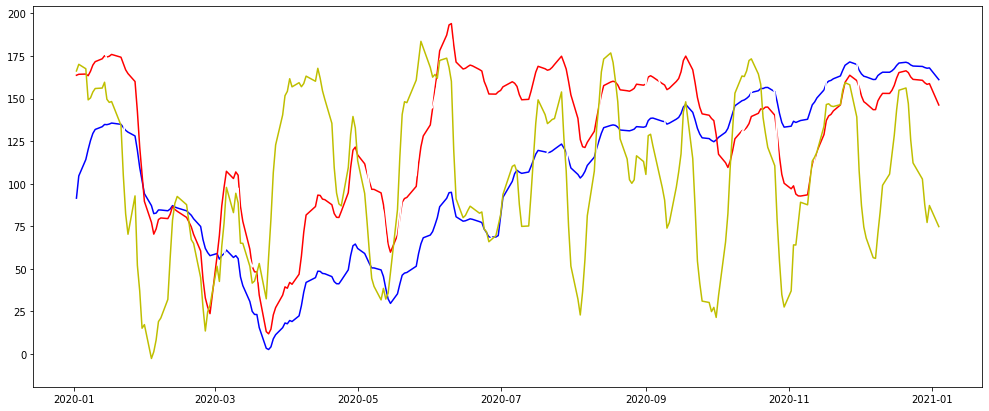

In [22]:
date = x["Date"]
fig, ax = plt.subplots(figsize=(17, 7))
#ax.plot(date, x["w_pre_avgrel"], color = 'b')
#ax.plot(date, x["w_avgdiff"], color = 'g')
ax.plot(date, x["q_SMI"], color = 'b')
ax.plot(date, x["m_SMI"], color = 'r')
ax.plot(date, x["w_SMI"], color = 'w')
ax.plot(date, x["2d_SMI"], color = 'y')

In [30]:
import plotly.express as px

# Create Line plot
fig = px.line(x, x=x['Date'], y=x['w_pre_avgdiff'])

# Add Scatter plot
#fig.add_scatter(x=x['Date'], y=x['m_SMI'])

# Add Scatter plot
#fig.add_scatter(x=x['Date'], y=x['w_SMI'])

# Add Scatter plot
#fig.add_scatter(x=x['Date'], y=x['2d_SMI'])

fig.show()

In [24]:
x.loc[5600:, ["Date", "Open","Close","High","Low","tt1w_Open","tt1w_Close","tt1w_High","tt1w_Low"]]

,Date,Open,Close,High,Low,tt1w_Open,tt1w_Close,tt1w_High,tt1w_Low
5600,2020-04-03,136.01,133.79,137.4350,132.9000,132.25,133.79,139.44,131.01
5601,2020-04-06,137.86,140.70,141.2500,136.9000,137.86,147.78,150.64,136.9
5602,2020-04-07,147.50,144.60,150.6399,144.3950,137.86,147.78,150.64,136.9
5603,2020-04-08,145.73,148.99,149.7231,143.9100,137.86,147.78,150.64,136.9
5604,2020-04-09,148.46,147.78,149.7300,146.5400,137.86,147.78,150.64,136.9
5605,2020-04-13,147.50,146.40,148.5790,145.3000,147.5,146.46,150.98,143.23
5606,2020-04-14,149.62,150.14,150.9800,148.0500,147.5,146.46,150.98,143.23
5607,2020-04-15,148.19,145.16,148.5500,144.9000,147.5,146.46,150.98,143.23
5608,2020-04-16,145.27,144.90,146.4450,143.2300,147.5,146.46,150.98,143.23
5609,2020-04-17,147.44,146.46,148.4950,144.8000,147.5,146.46,150.98,143.23


In [25]:
value = np.nan
value * 2

nan

In [26]:
def ExpMovingAvgTest(price, length):
    alpha = 2 / (length + 1)
    ema = []
    first_value = True
    
    for i in range(len(price)):
        if(str(price[i]) == "nan"):
            ema.append(np.nan)
        else:
            if first_value:
                # the first EMA is just the first price
                ema.append(price[i])
                first_value = False
            else:
                # the subsequent EMAs are calculated using the previous EMA
                # and the current price, using the formula above
                ema.append(alpha * price[i] + (1 - alpha) * ema[i - 1])  
    return ema

print(ExpMovingAvgTest([11.790,11.790,11.790,12.820,12.820,12.820,12.820,12.820],2))

[11.79, 11.79, 11.79, 12.476666666666667, 12.705555555555556, 12.781851851851853, 12.807283950617286, 12.815761316872429]
